In [60]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1" #! specify gpu here

import open3d as o3d # this might need to run before torch

import datetime
import matplotlib
import matplotlib.pyplot as plt

import time
import seaborn as sns
import json
import warnings
from pathlib import Path
import random
import base64
from io import BytesIO
import cv2
import vision_pipeline.obb
import imagesize
# from scipy import ndimage
import natsort
from PIL import Image as PILImage
from PIL import ImageDraw, ImageFilter
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from rich import print
from types import SimpleNamespace
import pickle
import imutils

# ros package
from context_action_framework.types import Detection, Label, Module, Camera
from sensor_msgs.msg import Image, CameraInfo # CameraInfo needed for pickle

# local imports
from vision_pipeline.helpers import Struct, make_valid_poly, img_to_camera_coords, scale_img, load_depth_data_from_filename
from context_action_framework.graph_relations import GraphRelations, exists_detection, compute_iou
from vision_pipeline.work_surface_detection_opencv import WorkSurfaceDetection
from vision_pipeline.object_detection_model import ObjectDetectionModel
from vision_pipeline.object_detection import ObjectDetection
from vision_pipeline.object_reid import ObjectReId

from vision_pipeline.config import load_config

from gap_detection.gap_detector_clustering import GapDetectorClustering

import rospy


rospy.init_node("test_node")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
depth_rescaling_factor = 1/1000

config = load_config(os.path.expanduser("~/vision_pipeline/config.yaml"))

config.reid = False

config.realsense.debug_clustering = False #! Set to True for debug text and more debug info on image

# pretend to use Basler camera
camera_type = Camera.realsense
# camera_name = camera_type.name

camera_config = config.realsense

camera_config.enable_topic = "set_sleeping" # basler camera specific
camera_config.enable_camera_invert = True # enable = True, but the topic is called set_sleeping, so the inverse
camera_config.use_worksurface_detection = True

model = ObjectDetectionModel(config.obj_detection)

object_detection = ObjectDetection(config, 
                                        camera_config,
                                        model=model,
                                        object_reid=None,
                                        camera=camera_type,
                                        frame_id="",
                                        use_ros=False)

gap_detector = GapDetectorClustering(config)

config:
{
    'node_name': 'vision',
    'reid': False,
    'basler': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 180,
        'topic': 'basler',
        'camera_node': '/basler',
        'image_topic': 'image_rect_color',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_graph_img': True,
        'has_depth': False,
        'run_continuous': False,
        'wait_for_services': False,
        'detect_arucos': False,
        'table_name': 'table_vision',
        'parent_frame': 'vision_table_zero',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'work_surface_ignore_border_width': 50,
        'show_work_surface_detection': False,
        'use_worksurface_detection': True,
        'debug_work_surface_detection': False
    },
    'realsense': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 0,
        'topic': 'realsense',
        'camera_node': '/realsense',
        'image_topic': 'color/image_raw',
        'info_topic': 'color/camera_info',
        'depth_topic': 'aligned_depth_to_color/image_raw',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_depth_img': True,
        'publish_cluster_img': True,
        'publish_graph_img': False,
        'has_depth': True,
        'compute_gaps': False,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'camera_height': 0.2,
        'parent_frame': 'panda_2/realsense',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'calibration_file': '~/vision_pipeline/realsense_calib/realsense_calib.yaml',
        'debug_clustering': False
    },
    'obj_detection': {
        'debug': True,
        'model': 'yolov8',
        'yolact_dataset_file': '~/vision_pipeline/data_limited/yolact/2023-07-18_firealarms_hcas/dataset.json',
        'yolact_score_threshold': 0.5,
        'yolov8_model_file': 
'~/vision_pipeline/data_limited/yolov8/output_2024-07-17_20000_incl_new_jsi_imgs_p2/epoch60.pt',
        'yolov8_score_threshold': 0.5,
        'superglue_templates': '~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped',
        'superglue_model_file': 
'~/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt',
        'superglue_match_threshold': 0.5,
        'rotation_median_filter': False,
        'superglue_visualise_to_file': False,
        'classifier_model_file': 
'~/vision_pipeline/data_limited/classifier/2024-07-19__14-32_classify/lightning_logs/version_0/checkpoints/epoch=33
9-step=339.ckpt',
        'classifier_threshold': 0.2
    }
}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.learning_rate 1e-05

model.batch_size 64

model.freeze_backbone False

curr_weights_path 
/home/docker/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt

Loaded SuperPoint model
Loaded SuperGlue model ("/home/docker/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt" weights)


100%|██████████| 61/61 [00:00<00:00, 188.23it/s]


Loaded superglue templates 61

In [62]:
# we want to compare the Yolov8 RGBD model to the clustering method.
# The validation dataset for YOLOv8 contains only the RGBD images.
# This bit of code gets the corresponding images in the dataset, where the .npy file and camera_info is also present

images_dir = Path("~/datasets2/reconcycle/2024-04-30_realsense_hcas").expanduser()
print("images_dir", images_dir)

yolo_val_path = Path("~/datasets2/reconcycle/2024-04-30_realsense_hcas/yolo_dataset_val_0.3/images/val").expanduser()

yolo_paths = list(yolo_val_path.glob('*.png')) + list(yolo_val_path.glob('*.jpg'))

file_names_without_ext = []
for image_val_path in yolo_paths:
    image_name_split = str(image_val_path.name).split("_", 1) # max split is 1
    folder = str(image_val_path.name).split("_")[0]
    image_name = image_name_split[1].replace("_RGBD", "")

    image_path_without_ext = Path(folder) / Path(image_name).stem
    file_names_without_ext.append(image_path_without_ext)

file_names_without_ext = natsort.os_sorted(file_names_without_ext)

print("file_names_without_ext", file_names_without_ext)

images_dir /home/docker/datasets2/reconcycle/2024-04-30_realsense_hcas

file_names_without_ext
[
    PosixPath('hca01/0023'),
    PosixPath('hca01/0024'),
    PosixPath('hca01/0027'),
    PosixPath('hca01/0028'),
    PosixPath('hca01/0119'),
    PosixPath('hca01/0123'),
    PosixPath('hca01/0124'),
    PosixPath('hca01/0129'),
    PosixPath('hca01/0130'),
    PosixPath('hca01/0132'),
    PosixPath('hca01/0202'),
    PosixPath('hca01/0204'),
    PosixPath('hca01/10026'),
    PosixPath('hca01/10036'),
    PosixPath('hca03/0002'),
    PosixPath('hca03/0005'),
    PosixPath('hca03/0009'),
    PosixPath('hca03/0010'),
    PosixPath('hca03/0101'),
    PosixPath('hca03/0105'),
    PosixPath('hca03/0106'),
    PosixPath('hca03/0108'),
    PosixPath('hca03/0109'),
    PosixPath('hca03/0113'),
    PosixPath('hca03/0211'),
    PosixPath('hca03/10001'),
    PosixPath('hca03/10008'),
    PosixPath('hca03/10050'),
    PosixPath('hca03/10051'),
    PosixPath('hca05/0134'),
    PosixPath('hca05/0138'),
    PosixPath('hca05/0140'),
    PosixPath('hca05/0143'),
    PosixPath('hca05/0213'),
    PosixPath('hca05/0218'),
    PosixPath('hca05/0219'),
    PosixPath('hca05/10010'),
    PosixPath('hca07/0013'),
    PosixPath('hca07/0014'),
    PosixPath('hca07/0017'),
    PosixPath('hca07/0018'),
    PosixPath('hca07/0162'),
    PosixPath('hca07/0168'),
    PosixPath('hca07/0170'),
    PosixPath('hca07/0176'),
    PosixPath('hca07/0182'),
    PosixPath('hca07/0222'),
    PosixPath('hca07/0224'),
    PosixPath('hca07/0226'),
    PosixPath('hca08/0147'),
    PosixPath('hca08/0151'),
    PosixPath('hca08/0152'),
    PosixPath('hca08/0154'),
    PosixPath('hca08/0156'),
    PosixPath('hca08/0158'),
    PosixPath('hca08/0230'),
    PosixPath('hca08/10037'),
    PosixPath('hca08/10039'),
    PosixPath('hca08/10040'),
    PosixPath('hca08/10042'),
    PosixPath('hca08/10043')
]

In [55]:
# images_dir = Path(os.path.expanduser("~/datasets2/reconcycle/2024-04-30_realsense_hcas"))

# images_dir = Path(os.path.expanduser("~/datasets2/reconcycle/2024-04-30_realsense_hcas/2024-08-22_10:21:38_realsense"))

images_dir = Path(os.path.expanduser("~/datasets2/reconcycle/2024-04-30_realsense_hcas/hca01"))

subfolders = natsort.os_sorted([d for d in list(Path(images_dir).glob('*/')) if d.is_dir() and 'yolo' not in d.name])

# add root folder too:
subfolders.append(images_dir)

file_names_without_ext = []
for subfolder in subfolders:

    image_paths = list(Path(subfolder).glob('*.jpg'))
    image_paths = [path for path in image_paths if "viz" not in str(path.stem)]
    image_paths = natsort.os_sorted(image_paths)
    if subfolder == images_dir:
        file_names_without_ext.extend([path.stem for path in image_paths])
    else:
        file_names_without_ext.extend([Path(subfolder.name) / Path(path.stem) for path in image_paths])

# file_names_without_ext = ["0007"]

print("file_names_without_ext", file_names_without_ext)

file_names_without_ext
[
    '0021',
    '0022',
    '0023',
    '0024',
    '0025',
    '0026',
    '0027',
    '0028',
    '0029',
    '0030',
    '0118',
    '0119',
    '0120',
    '0121',
    '0122',
    '0123',
    '0124',
    '0125',
    '0126',
    '0127',
    '0128',
    '0129',
    '0130',
    '0131',
    '0132',
    '0201',
    '0202',
    '0203',
    '0204',
    '0205',
    '10023',
    '10024',
    '10025',
    '10026',
    '10027',
    '10028',
    '10029',
    '10030',
    '10031',
    '10032',
    '10033',
    '10034',
    '10035',
    '10036'
]

In [63]:
def run_gap_detection(colour_img, depth_img, camera_info):

    time0 = time.time()
    
    labelled_img, detections, markers, poses, graph_img, graph_relations = object_detection.get_prediction(colour_img, depth_img=depth_img, worksurface_detection=None, extra_text=None, camera_info=camera_info, use_tracker=False, use_classify=True)

    time1 = time.time()

    if depth_img is not None:
        gaps, cluster_img, device_mask, depth_masked_ma, depth_scaled, depth_scaled_masked, depth_gaussian, depth_opening \
            = gap_detector.lever_detector(
                colour_img,
                depth_img,
                detections,
                graph_relations,
                camera_info
            )
        
        time2 = time.time()

        time_segmentation = time1 - time0
        time_levering = time2 - time1
        
        return labelled_img, depth_scaled, cluster_img, depth_gaussian, depth_opening, time_segmentation, time_levering

making folder /home/docker/vision_pipeline/saves/2024-08-23_13:18:19_test_gap_detection

classify: kalo2, 01, conf: 0.73

elapsed_time_classify_and_rot 0.02051219900022261

hca depth_robust_min 0.299

internals depth_robust_min 0.299

battery depth_robust_min 0.301

detection: NOT A SCREW battery invalid: edge too small: 0.009m

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.6388120651245117

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.15453410148620605

time levering 6.959186553955078

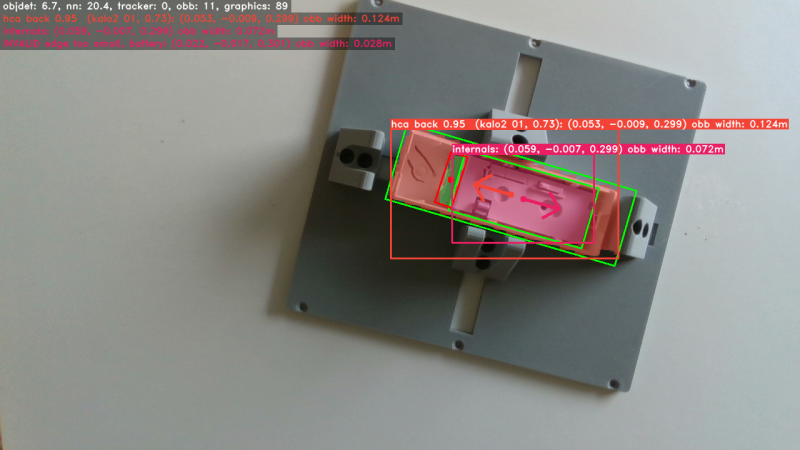

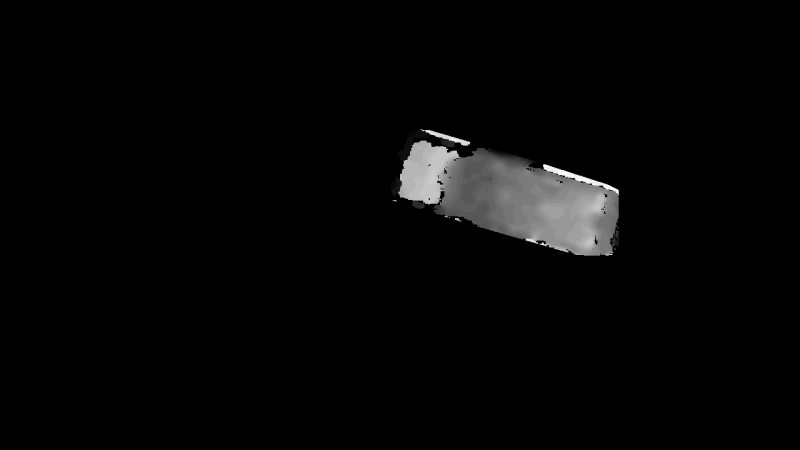

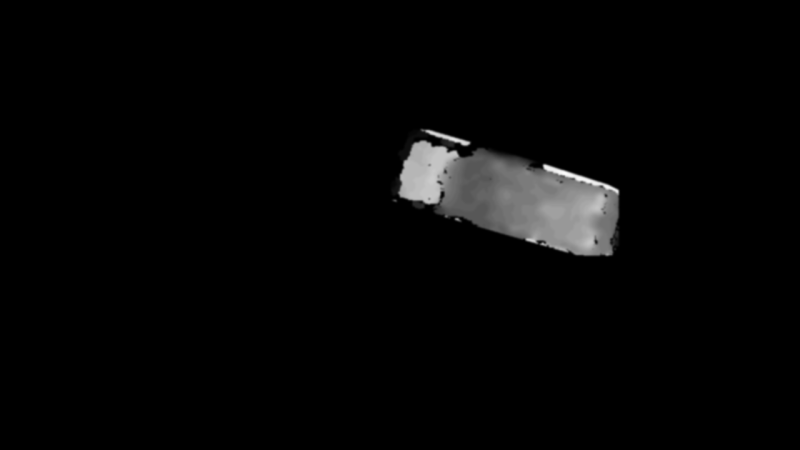

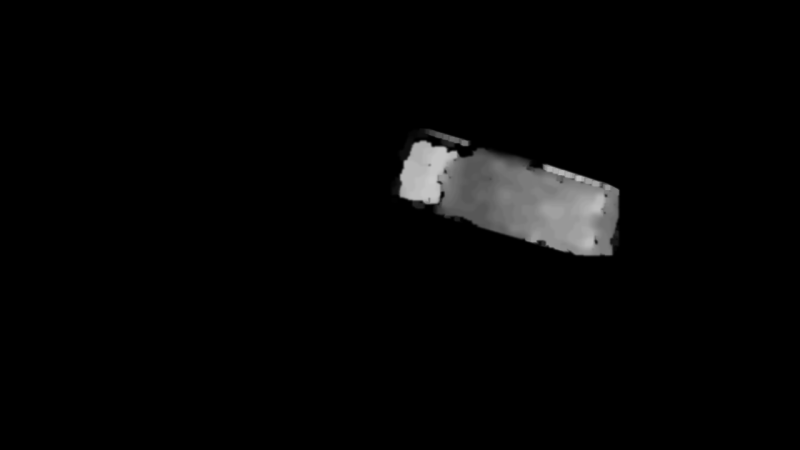

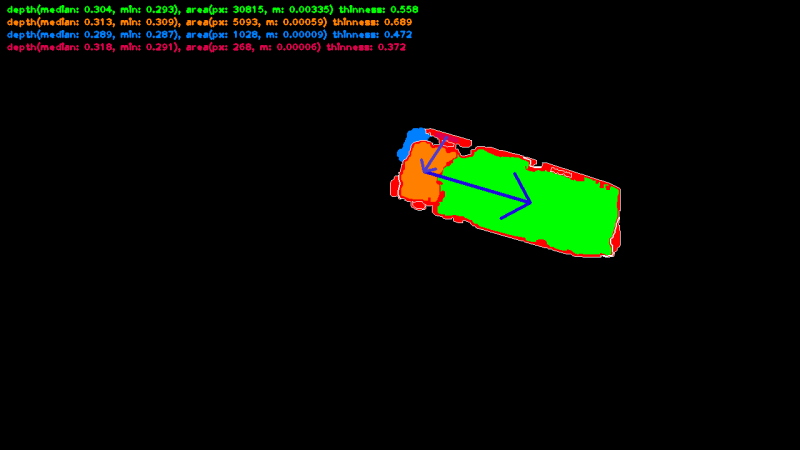

classify: kalo2, 01, conf: 0.48

elapsed_time_classify_and_rot 0.022491216004709713

hca depth_robust_min 0.296

internals depth_robust_min 0.300

battery depth_robust_min 0.301

detection: NOT A SCREW battery invalid: edge too small: 0.01m

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.8295023441314697

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.14440739154815674

time levering 7.0970155000686646

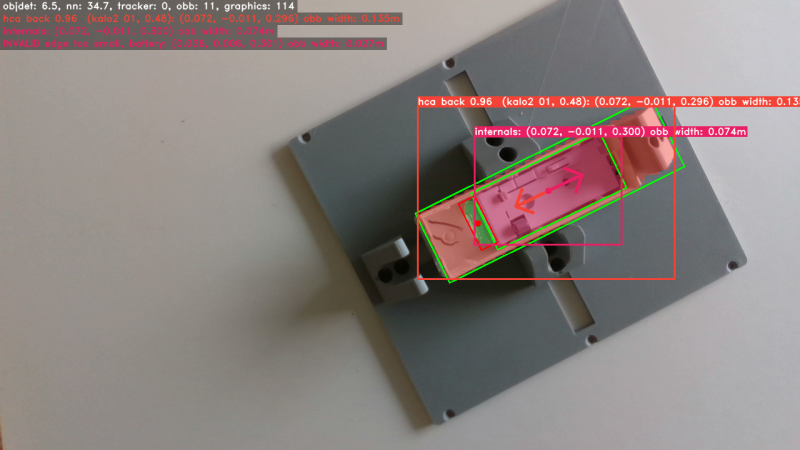

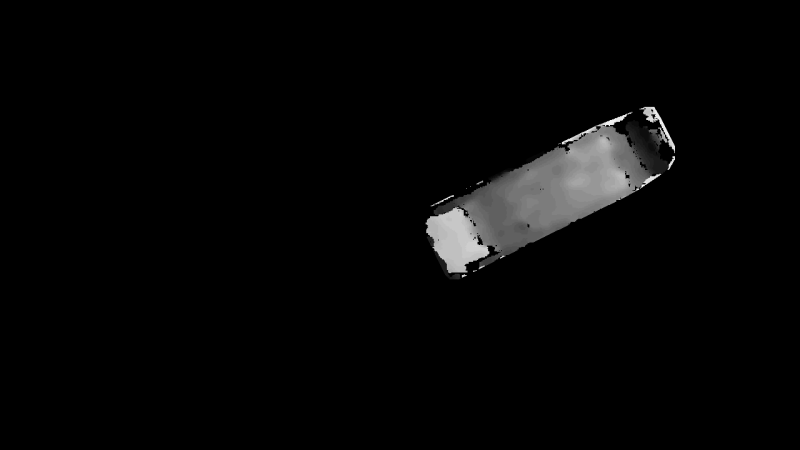

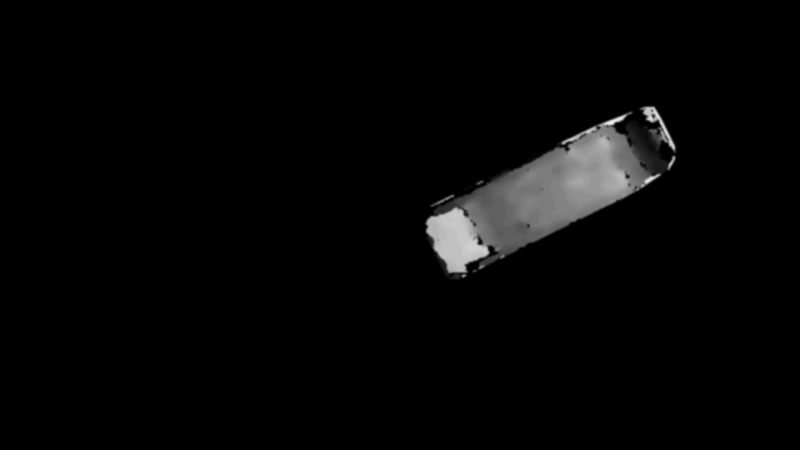

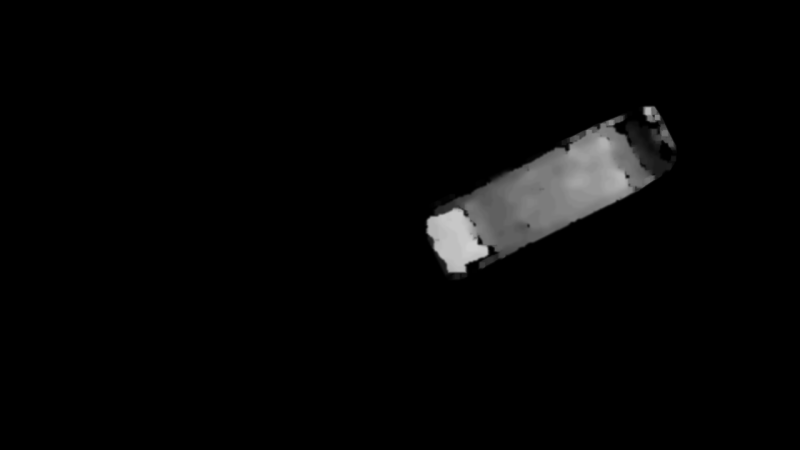

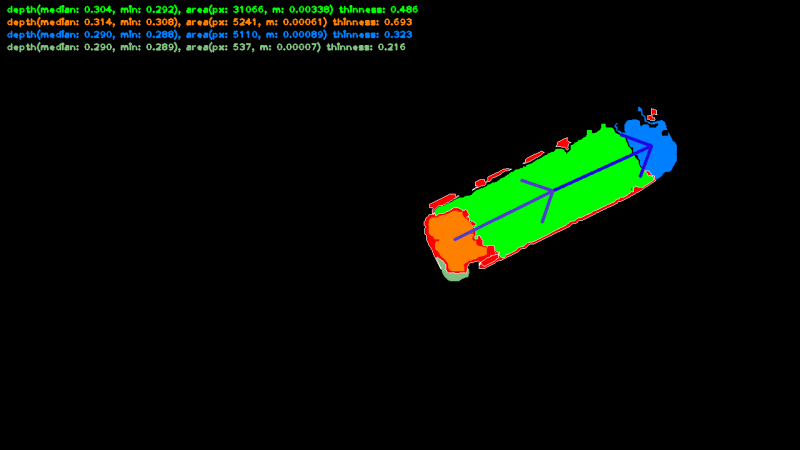

classify: kalo2, 01, conf: 0.57

elapsed_time_classify_and_rot 0.01646505101234652

hca depth_robust_min 0.370

internals depth_robust_min 0.374

trying again with dilated mask!

 no depth info! battery

battery depth_robust_min 0.376

detection: battery obb is None!

detection: NOT A SCREW battery invalid: edge too small: 0.008m

median depth: 0.396

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.0661070346832275

polygon 2 is completely inside polygon1

time segmentation 0.1479369799296061

time levering 6.8479641278584795

classify: kalo2, 01, conf: 0.56

elapsed_time_classify_and_rot 0.014155484008369967

hca depth_robust_min 0.371

internals depth_robust_min 0.372

trying again with dilated mask!

 no depth info! battery

battery depth_robust_min 0.374

detection: battery obb is None!

detection: NOT A SCREW battery invalid: edge too small: 0.008m

median depth: 0.397

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.1098003387451172

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.369 < 0.366 + 0.005 = 0.371

time segmentation 0.14911037683486938

time levering 6.7324522733688354

classify: kalo2, 01, conf: 0.99

elapsed_time_classify_and_rot 0.021323772001778707

hca depth_robust_min 0.302

internals depth_robust_min 0.301

battery depth_robust_min 0.305

detection: NOT A SCREW battery invalid: edge too small: 0.008m

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.3634192943572998

time segmentation 0.14577369689941405

time levering 6.714315176010132

classify: kalo2, 01, conf: 0.99

elapsed_time_classify_and_rot 0.018785087988362648

internals depth_robust_min 0.301

hca depth_robust_min 0.302

battery depth_robust_min 0.302

detection: NOT A SCREW battery invalid: edge too small: 0.006m

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.3031203746795654

len(polygon_coords) 13

len(polygon_coords_m) 0

polygon 2 is completely inside polygon1

0.306 < 0.303 + 0.005 = 0.308

time segmentation 0.1412830352783203

time levering 6.694171229998271

classify: kalo2, 01, conf: 0.99

elapsed_time_classify_and_rot 0.02140553000208456

hca depth_robust_min 0.302

internals depth_robust_min 0.302

battery depth_robust_min 0.302

detection: NOT A SCREW battery invalid: edge too small: 0.008m

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.4303257465362549

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.306 < 0.305 + 0.005 = 0.310

time segmentation 0.13958045414515904

time levering 6.6961151872362406

classify: kalo2, 01, conf: 0.89

elapsed_time_classify_and_rot 0.019419496995396912

hca depth_robust_min 0.296

internals depth_robust_min 0.296

battery depth_robust_min 0.298

detection: NOT A SCREW battery invalid: edge too small: 0.007m

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.7378034591674805

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.301 < 0.300 + 0.005 = 0.305

0.288 < 0.287 + 0.005 = 0.292

time segmentation 0.1383206844329834

time levering 6.739272981882095

classify: kalo2, 01, conf: 0.71

elapsed_time_classify_and_rot 0.019887847010977566

hca depth_robust_min 0.296

internals depth_robust_min 0.296

battery depth_robust_min 0.297

detection: NOT A SCREW battery invalid: edge too small: 0.006m

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5475001335144043

len(polygon_coords) 26

len(polygon_coords_m) 0

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.137027555041843

time levering 6.746963262557983

classify: kalo2, 01, conf: 0.90

elapsed_time_classify_and_rot 0.018707549999817275

hca depth_robust_min 0.296

internals depth_robust_min 0.296

battery depth_robust_min 0.297

detection: NOT A SCREW battery invalid: edge too small: 0.008m

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.4746365547180176

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.13691892623901367

time levering 6.746291661262513

classify: kalo2, 01, conf: 0.98

elapsed_time_classify_and_rot 0.017393686997820623

hca depth_robust_min 0.301

internals depth_robust_min 0.301

battery depth_robust_min 0.301

detection: NOT A SCREW battery invalid: edge too small: 0.007m

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5941667556762695

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.13508746840737082

time levering 6.7631824666803535

classify: kalo2, 01, conf: 0.96

elapsed_time_classify_and_rot 0.020521048005321063

hca depth_robust_min 0.301

internals depth_robust_min 0.301

battery depth_robust_min 0.302

detection: NOT A SCREW battery invalid: edge too small: 0.008m

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5550599098205566

len(polygon_coords) 66

len(polygon_coords_m) 0

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.1357922156651815

time levering 6.773955921332042

classify: kalo2, 01, conf: 0.59

elapsed_time_classify_and_rot 0.018334230000618845

hca depth_robust_min 0.296

internals depth_robust_min 0.296

battery depth_robust_min 0.297

detection: NOT A SCREW battery invalid: edge too small: 0.009m

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5618960857391357

len(polygon_coords) 17

len(polygon_coords_m) 0

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.13492969366220328

time levering 6.80156161234929

classify: kalo2, 01, conf: 0.71

elapsed_time_classify_and_rot 0.02190108099603094

hca depth_robust_min 0.296

internals depth_robust_min 0.296

battery depth_robust_min 0.297

detection: NOT A SCREW battery invalid: edge too small: 0.007m

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.6248829364776611

len(polygon_coords) 20

len(polygon_coords_m) 0

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.13490828445979527

time levering 6.820204598563058

classify: kalo, 03, conf: 0.91

classify: caloric, 07, conf: 0.40

elapsed_time_classify_and_rot 0.022528850997332484

hca depth_robust_min 0.296

internals depth_robust_min 0.299

battery depth_robust_min 0.295

hca depth_robust_min 0.287

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5731158256530762

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.303 < 0.301 + 0.005 = 0.306

0.303 < 0.302 + 0.005 = 0.307

0.305 < 0.301 + 0.005 = 0.306

0.305 < 0.303 + 0.005 = 0.308

0.305 < 0.302 + 0.005 = 0.307

0.302 < 0.301 + 0.005 = 0.306

time segmentation 0.1357913653055827

time levering 6.825053183237712

classify: kalo, 03, conf: 0.83

elapsed_time_classify_and_rot 0.018527587002608925

hca depth_robust_min 0.373

internals depth_robust_min 0.375

battery depth_robust_min 0.373

median depth: 0.395

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 0.9816055297851562

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.377 < 0.376 + 0.005 = 0.381

time segmentation 0.13487344980239868

time levering 6.787632375955582

classify: kalo, 03, conf: 0.89

elapsed_time_classify_and_rot 0.014647393996710889

hca depth_robust_min 0.368

internals depth_robust_min 0.371

battery depth_robust_min 0.368

median depth: 0.397

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.0727243423461914

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.13372400227714987

time levering 6.767979257247028

classify: kalo, 03, conf: 0.66

elapsed_time_classify_and_rot 0.014772844995604828

hca depth_robust_min 0.368

internals depth_robust_min 0.373

battery depth_robust_min 0.370

median depth: 0.396

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.079756736755371

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.386 < 0.385 + 0.005 = 0.390

time segmentation 0.13272151682111952

time levering 6.743151439560784

classify: kalo, 03, conf: 1.00

elapsed_time_classify_and_rot 0.01911572199605871

hca depth_robust_min 0.300

internals depth_robust_min 0.302

battery depth_robust_min 0.299

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.4642510414123535

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.304 < 0.300 + 0.005 = 0.305

time segmentation 0.13301851874903628

time levering 6.740944774527299

classify: kalo, 03, conf: 0.99

elapsed_time_classify_and_rot 0.020596624992322177

hca depth_robust_min 0.300

internals depth_robust_min 0.302

battery depth_robust_min 0.299

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.622450590133667

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.303 < 0.299 + 0.005 = 0.304

time segmentation 0.13307379484176635

time levering 6.7541522741317745

classify: kalo, 03, conf: 0.99

elapsed_time_classify_and_rot 0.021374524003476836

hca depth_robust_min 0.300

internals depth_robust_min 0.302

battery depth_robust_min 0.299

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.515575647354126

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.315 < 0.313 + 0.005 = 0.318

0.316 < 0.315 + 0.005 = 0.320

0.316 < 0.313 + 0.005 = 0.318

time segmentation 0.13346099853515625

time levering 6.7557994070507235

classify: kalo, 03, conf: 1.00

elapsed_time_classify_and_rot 0.018406541988952085

hca depth_robust_min 0.300

internals depth_robust_min 0.302

battery depth_robust_min 0.299

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5339934825897217

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.303 < 0.302 + 0.005 = 0.307

time segmentation 0.1332031488418579

time levering 6.7593160976063125

classify: kalo, 03, conf: 0.98

elapsed_time_classify_and_rot 0.018290354011696763

hca depth_robust_min 0.301

internals depth_robust_min 0.302

battery depth_robust_min 0.300

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.4131417274475098

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.304 < 0.300 + 0.005 = 0.305

0.315 < 0.313 + 0.005 = 0.318

0.315 < 0.314 + 0.005 = 0.319

0.314 < 0.313 + 0.005 = 0.318

time segmentation 0.13307402444922406

time levering 6.765014119770216

classify: kalo, 03, conf: 0.99

elapsed_time_classify_and_rot 0.01916755900310818

hca depth_robust_min 0.300

internals depth_robust_min 0.302

battery depth_robust_min 0.299

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5352959632873535

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.305 < 0.303 + 0.005 = 0.308

time segmentation 0.13394691546758017

time levering 6.766960561275482

classify: kalo, 03, conf: 0.99

elapsed_time_classify_and_rot 0.023573968006530777

hca depth_robust_min 0.300

internals depth_robust_min 0.302

battery depth_robust_min 0.299

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5422489643096924

len(polygon_coords) 32

len(polygon_coords_m) 1

len(polygon_coords) 44

len(polygon_coords_m) 3

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.303 < 0.302 + 0.005 = 0.307

0.303 < 0.302 + 0.005 = 0.307

time segmentation 0.1341364574432373

time levering 6.768384885787964

classify: kalo, 03, conf: 0.85

elapsed_time_classify_and_rot 0.02031438800622709

hca depth_robust_min 0.298

internals depth_robust_min 0.300

battery depth_robust_min 0.297

median depth: 0.324

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.504814863204956

len(polygon_coords) 76

len(polygon_coords_m) 3

polygon 2 is completely inside polygon1

time segmentation 0.13460507759681115

time levering 6.7788496384253865

classify: kalo, 03, conf: 0.69

elapsed_time_classify_and_rot 0.019460038995021023

hca depth_robust_min 0.295

internals depth_robust_min 0.297

battery depth_robust_min 0.294

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.7256648540496826

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.310 < 0.307 + 0.005 = 0.312

time segmentation 0.13403179027416087

time levering 6.78834914278101

classify: kalo, 03, conf: 0.73

elapsed_time_classify_and_rot 0.02016828299383633

hca depth_robust_min 0.295

internals depth_robust_min 0.297

battery depth_robust_min 0.294

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.7574784755706787

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.298 < 0.294 + 0.005 = 0.299

0.298 < 0.294 + 0.005 = 0.299

time segmentation 0.13412977967943465

time levering 6.7949104734829495

classify: kalo, 03, conf: 0.65

elapsed_time_classify_and_rot 0.023572339996462688

hca depth_robust_min 0.295

internals depth_robust_min 0.297

battery depth_robust_min 0.294

internals depth_robust_min 0.283

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.7313785552978516

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.298 < 0.295 + 0.005 = 0.300

time segmentation 0.13469363081044164

time levering 6.808729928115318

classify: ecotron, 05, conf: 0.52

elapsed_time_classify_and_rot 0.019534690989530645

hca depth_robust_min 0.298

pcb depth_robust_min 0.301

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.9679350852966309

time segmentation 0.13445374965667725

time levering 6.820705803235372

classify: ecotron, 05, conf: 0.82

elapsed_time_classify_and_rot 0.019213484003557824

pcb depth_robust_min 0.307

hca depth_robust_min 0.304

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.5556859970092773

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.300 < 0.298 + 0.005 = 0.303

0.303 < 0.300 + 0.005 = 0.305

0.317 < 0.316 + 0.005 = 0.321

time segmentation 0.13373212660512618

time levering 6.824232009149367

classify: ecotron, 05, conf: 0.69

elapsed_time_classify_and_rot 0.017863545988802798

pcb depth_robust_min 0.306

hca depth_robust_min 0.303

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.6390535831451416

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.302 < 0.299 + 0.005 = 0.304

0.303 < 0.302 + 0.005 = 0.307

0.303 < 0.299 + 0.005 = 0.304

time segmentation 0.13299475610256195

time levering 6.83386405557394

classify: ecotron, 05, conf: 0.44

elapsed_time_classify_and_rot 0.02030689100502059

hca depth_robust_min 0.306

pcb depth_robust_min 0.306

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.569906234741211

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.308 < 0.307 + 0.005 = 0.312

time segmentation 0.13238659049525406

time levering 6.833941878694477

classify: ecotron, 05, conf: 0.87

elapsed_time_classify_and_rot 0.0206405380013166

pcb depth_robust_min 0.302

hca depth_robust_min 0.301

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.8710048198699951

len(polygon_coords) 41

len(polygon_coords_m) 1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.313 < 0.312 + 0.005 = 0.317

time segmentation 0.13187510125777302

time levering 6.841676669962266

classify: ecotron, 05, conf: 0.87

elapsed_time_classify_and_rot 0.021984038001392037

hca depth_robust_min 0.304

pcb depth_robust_min 0.306

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.7666280269622803

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.300 < 0.299 + 0.005 = 0.304

0.321 < 0.320 + 0.005 = 0.325

0.300 < 0.299 + 0.005 = 0.304

0.301 < 0.300 + 0.005 = 0.305

0.301 < 0.299 + 0.005 = 0.304

0.301 < 0.300 + 0.005 = 0.305

time segmentation 0.13152798243931363

time levering 6.849289771488735

classify: ecotron, 05, conf: 0.90

elapsed_time_classify_and_rot 0.016919756002607755

pcb depth_robust_min 0.306

hca depth_robust_min 0.304

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.773423671722412

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.301 < 0.298 + 0.005 = 0.303

0.318 < 0.314 + 0.005 = 0.319

0.318 < 0.314 + 0.005 = 0.319

time segmentation 0.1309797763824463

time levering 6.85480354891883

classify: ecotron, 05, conf: 0.88

elapsed_time_classify_and_rot 0.018974655991769396

hca depth_robust_min 0.297

pcb depth_robust_min 0.300

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.8147547245025635

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.302 < 0.298 + 0.005 = 0.303

0.298 < 0.297 + 0.005 = 0.302

time segmentation 0.13050676680899956

time levering 6.867120098423314

classify: caloric, 07, conf: 0.95

elapsed_time_classify_and_rot 0.014191693000611849

hca depth_robust_min 0.292

internals depth_robust_min 0.299

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.422865867614746

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.293 < 0.288 + 0.005 = 0.293

0.294 < 0.293 + 0.005 = 0.298

time segmentation 0.1296507057390715

time levering 6.865985261766534

classify: caloric, 07, conf: 0.72

elapsed_time_classify_and_rot 0.014429570990614593

hca depth_robust_min 0.294

internals depth_robust_min 0.299

internals depth_robust_min 0.289

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 1.4606666564941406

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.294 < 0.293 + 0.005 = 0.298

0.295 < 0.294 + 0.005 = 0.299

0.295 < 0.293 + 0.005 = 0.298

time segmentation 0.12930726393675193

time levering 6.862908797386365

classify: caloric, 07, conf: 0.39

elapsed_time_classify_and_rot 0.014904490002663806

hca depth_robust_min 0.368

internals depth_robust_min 0.373

battery depth_robust_min 0.404

median depth: 0.396

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 0.9345550537109375

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

0.368 < 0.366 + 0.005 = 0.371

time segmentation 0.12901208996772767

time levering 6.846111166477203

classify: caloric, 07, conf: 0.92

elapsed_time_classify_and_rot 0.014603113988414407

hca depth_robust_min 0.368

internals depth_robust_min 0.373

battery depth_robust_min 0.402

median depth: 0.396

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


depth_scaled 0 255

time clustering: 0.9230022430419922

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

polygon 2 is completely inside polygon1

time segmentation 0.12866640672451113

time levering 6.827957589451859

classify: caloric, 07, conf: 0.67

elapsed_time_classify_and_rot 0.014322952993097715

hca depth_robust_min 0.290

internals depth_robust_min 0.298

internals depth_robust_min 0.285

internals depth_robust_min 0.284

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  # filtering camara defects, where depth = 0


KeyboardInterrupt: 

In [65]:
save_path = Path("~/vision_pipeline/saves/{date:%Y-%m-%d_%H:%M:%S}_test_gap_detection".format(date=datetime.datetime.now())).expanduser()
# check if file path is empty
if not os.path.exists(save_path):
    print("making folder", save_path)
    os.makedirs(save_path)
else:
    raise ValueError(f"folder already exists! {save_path}")

times_segmentation = []
times_levering = []
for idx, file_name_without_ext in enumerate(file_names_without_ext):
    colour_img, depth_vis_img, depth_img, camera_info = load_depth_data_from_filename(file_name_without_ext, images_dir)
    
    labelled_img, depth_scaled, cluster_img, depth_gaussian, depth_opening, time_segmentation, time_levering = run_gap_detection(colour_img, depths_img, camera_info)

    times_segmentation.append(time_segmentation)
    times_levering.append(time_levering)

    print(f"time segmentation {np.mean(times_segmentation)}")
    print(f"time levering {np.mean(times_levering)}")

    if "/" in str(file_name_without_ext):
        save_file_name = f"{file_name_without_ext.parent}_{file_name_without_ext.stem}"
    else:
        save_file_name = file_name_without_ext
    cv2.imwrite(str(save_path / Path(f"{save_file_name}_labelled.jpg")), labelled_img)
    cv2.imwrite(str(save_path / Path(f"{save_file_name}_depth.jpg")), depth_scaled)
    cv2.imwrite(str(save_path / Path(f"{save_file_name}_cluster.jpg")), cluster_img)

    depth_scaled_bgr = cv2.cvtColor(depth_scaled, cv2.COLOR_GRAY2BGR)
    depth_opening_bgr = cv2.cvtColor(depth_opening, cv2.COLOR_GRAY2BGR)
    first_row = np.hstack((labelled_img, depth_scaled_bgr))
    second_row = np.hstack((cluster_img, depth_opening_bgr))
    grid = np.vstack((first_row, second_row))
    cv2.imwrite(str(save_path / Path(f"{save_file_name}_all.jpg")), grid)

    if idx < 2:
        display(PILImage.fromarray(scale_img(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB))))
        display(PILImage.fromarray(scale_img(cv2.cvtColor(depth_scaled, cv2.COLOR_BGR2RGB))))
        display(PILImage.fromarray(scale_img(cv2.cvtColor(depth_gaussian, cv2.COLOR_BGR2RGB))))
        display(PILImage.fromarray(scale_img(cv2.cvtColor(depth_opening, cv2.COLOR_BGR2RGB))))
        display(PILImage.fromarray(scale_img(cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB))))
        # display(PILImage.fromarray(scale_img(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))))

    # if idx > 1:
    #     break #! DEBUG.



In [5]:

# TODO: 1. load the depth, and camera info
# TODO: 2. run the detections
# TODO: 3. get the clustering


labelled_img, detections, markers, poses, graph_img, graph_relations = object_detection.get_prediction(colour_img, depth_img=depth_img, worksurface_detection=None, extra_text=None, camera_info=camera_info, use_tracker=False, use_classify=True)

#! specify use_classify=True if you want it to classify and estimate rotation

display(PILImage.fromarray(scale_img(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB))))

if depth_img is not None:
    gaps, cluster_img, device_mask, depth_masked_ma, depth_scaled, depth_scaled_masked \
        = gap_detector.lever_detector(
            colour_img,
            depth_img,
            detections,
            graph_relations,
            camera_info
        )

# plt.imshow(labelled_img)
# plt.show()


graph_relations_text = graph_relations.to_text()
print("graph:", graph_relations_text)
print("list_wc_components", graph_relations.list_wc_components)
print("detections", len(detections))

# print("detections", detections)


    # print("gaps", gaps)

# print("depth_scaled:")

# plt.imshow(depth_scaled)
# plt.show()

print("depth_scaled_masked:")

plt.imshow(depth_scaled_masked)
plt.show()

#################################################################
from skimage.filters import threshold_otsu

print("Gaussian blur on depth_scaled:")

depth_gaussian = cv2.GaussianBlur(depth_scaled, (21, 21), 0)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(depth_gaussian)

print("depth_gaussian: maxLoc", maxLoc)

plt.imshow(depth_gaussian)
plt.plot(maxLoc[0], maxLoc[1], 'r.')
plt.show()

# _, image2 = cv2.threshold(depth_gaussian, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# print("depth_scaled_masked.shape", depth_scaled_masked.shape)
# print("min depth_scaled_masked", np.min(depth_scaled_masked))
# print("max depth_scaled_masked", np.max(depth_scaled_masked))
# print("median depth_scaled_masked", np.median(depth_scaled_masked))

# otsu_threshold = threshold_otsu(depth_scaled)

# binary_otsu = depth_scaled > otsu_threshold

# print("otsu thresholding:")
# plt.imshow(binary_otsu)
# plt.show()


##################################################################
# import hdbscan

# hdbscan_fit = hdbscan.HDBSCAN(min_cluster_size=20).fit_predict(depth_scaled)

# print("len(hdbscan_fit)", len(hdbscan_fit))

# plt.imshow(hdbscan_fit)
# plt.show()

###################################################################
# https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_holes_and_peaks.html

# from skimage.morphology import reconstruction

# seed = np.copy(depth_scaled)
# seed[1:-1, 1:-1] = depth_scaled.max()
# mask = depth_scaled

# filled = reconstruction(seed, mask, method='erosion')

# print("skimage reconstruction")

# plt.imshow(filled)
# plt.show()


###################################################################
# from scipy.ndimage.filters import maximum_filter
# from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
# from skimage.feature import peak_local_max

# def detect_peaks(image):
#     """
#     Takes an image and detect the peaks usingthe local maximum filter.
#     Returns a boolean mask of the peaks (i.e. 1 when
#     the pixel's value is the neighborhood maximum, 0 otherwise)
#     """

#     # define an 8-connected neighborhood
#     neighborhood = generate_binary_structure(2,2)

#     print("neighborhood.shape", neighborhood.shape)

#     #apply the local maximum filter; all pixel of maximal value 
#     #in their neighborhood are set to 1
#     max_filter = maximum_filter(image, size=4)
#     # max_filter = maximum_filter(image, footprint=neighborhood)
#     local_max = max_filter == image
#     #local_max is a mask that contains the peaks we are 
#     #looking for, but also the background.
#     #In order to isolate the peaks we must remove the background from the mask.

#     j, i = np.where(local_max)
#     coordinates_2 = np.array(zip(i,j))
#     print("coordinates_2.shape", coordinates_2.shape)


#     # coordinates = peak_local_max(image, min_distance=20)


#     print("max filter:")
#     plt.imshow(max_filter)
#     # plt.plot(coordinates_2[:, 0], coordinates_2[:, 1], 'r.')
#     plt.show()

#     print("local max:")
#     plt.imshow(local_max)
#     plt.show()


#     #we create the mask of the background
#     background = (image==0)

#     #a little technicality: we must erode the background in order to 
#     #successfully subtract it form local_max, otherwise a line will 
#     #appear along the background border (artifact of the local maximum filter)
#     eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

#     #we obtain the final mask, containing only peaks, 
#     #by removing the background from the local_max mask (xor operation)
#     detected_peaks = local_max ^ eroded_background

#     return detected_peaks

# peak_dets = detect_peaks(depth_scaled)



# plt.imshow(peak_dets)
# plt.show()

##########################################################

# from scipy.signal import argrelextrema
# local_max = argrelextrema(depth_scaled, np.greater)

# print("local_max", local_max)

# print("depth_scaled.shape", depth_scaled.shape)

############################################################

depth_grad = np.gradient(depth_gaussian) # a list of two arrays

print("np.min(depth_grad)", np.min(depth_grad))
print("np.max(depth_grad)", np.max(depth_grad))

grad_total = depth_grad[0] + depth_grad[1]
# print("depth_scaled", depth_scaled.shape)

plt.imshow(grad_total)
plt.colorbar()
plt.show()

# plt.imshow(depth_grad[0])
# plt.colorbar()
# plt.show()

# plt.imshow(depth_grad[1])
# plt.colorbar()
# plt.show()

##############################################################


# display(PILImage.fromarray(scale_img(cv2.cvtColor(depth_grad, cv2.COLOR_BGR2RGB))))

display(PILImage.fromarray(scale_img(cv2.cvtColor(depth_scaled, cv2.COLOR_BGR2RGB))))

# display(PILImage.fromarray(cv2.cvtColor(depth_masked, cv2.COLOR_BGR2RGB)))


display(PILImage.fromarray(scale_img(cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB))))


# ! How about this: 
# https://stackoverflow.com/questions/62745825/2d-local-maxima-and-minima-in-python
# cv2.filter2D

# https://stackoverflow.com/questions/77109279/how-do-i-locate-minima-in-an-array

# https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array


NameError: name 'colour_img' is not defined